In [ ]:
!pip install scikit-maad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install kymatio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch

from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam

from scipy.io import wavfile
import os
import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from kymatio.torch import Scattering1D
from kymatio.datasets import fetch_fsdd

In [ ]:
# First, we have signal length. Longer signals are truncated and shorter signals are zero-padded. 
# The sampling rate is 8000 Hz, so this corresponds to little over a second.

T = 2**13
# Maximum scale 2**J of the scattering transform (here, about 30 milliseconds) and the number of wavelets per octave.

J = 8
Q = 12
# We need a small constant to add to the scattering coefficients before computing the logarithm. This prevents very large values when the scattering coefficients are very close to zero.

log_eps = 1e-6
#If a GPU is available, let’s use it!
use_cuda = torch.cuda.is_available()
#For reproducibility, we fix the seed of the random number generator.
torch.manual_seed(42)

In [ ]:
info_data = fetch_fsdd()
files = info_data['files']
path_dataset = info_data['path_dataset']

In [ ]:
x_all = torch.zeros(len(files), T, dtype=torch.float32)
y_all = torch.zeros(len(files), dtype=torch.int64)
subset = torch.zeros(len(files), dtype=torch.int64)

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

from librosa import feature
from maad import sound
from time import time
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


sns.set_theme()
plt.rcParams["figure.figsize"] = (17, 5)

In [ ]:
from maad import util, sound, features

from maad.util import power2dB, plot2d
from skimage import transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF

In [ ]:
### librosa
import librosa as lr
import librosa.display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def transform(s, fs, wtype='hann', nperseg=512, noverlap=0, db_range=60, db_gain=30):
    """ Compute decibel spectrogram """
    Sxx, tn, fn, ext = sound.spectrogram(s, fs, wtype, nperseg, noverlap)            
    Sxx = util.power2dB(Sxx, db_range, db_gain)
    return Sxx, tn, fn, ext

In [ ]:
#%% Set variables
path_annotations = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio_labels.csv'  # manual annotations in csv table
path_audio = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/data/ANH_RAIN_DATASET/audio/'  # directory where the audio data is located
path_results = '/content/drive/MyDrive/DS4All_Cohort6_Team_172/Code/results/'
target_fs = 10000  # set target sampling rate for audio

In [ ]:
#%% Load annotations
df = pd.read_csv(path_annotations)  

In [ ]:
df.shape

(1104, 7)

In [ ]:
df.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav


In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

classifier = LogisticRegression(penalty='l1',class_weight='balanced',max_iter=2666,solver='saga')

# Pipeline, should we normalize/standarize?
pipe = Pipeline ([#("cleaner", predictors()),
                 #("standarize", ),
                 ("classifier", classifier)])

In [ ]:
# Classifiers to use
clfs = [LinearSVC(class_weight='balanced'),
        SGDClassifier(class_weight='balanced'),
        SVC(kernel='rbf',degree=3,gamma='scale',class_weight='balanced'),
        LogisticRegression(penalty='l1',class_weight='balanced',solver='saga'),
        DecisionTreeClassifier(class_weight='balanced'),
        RandomForestClassifier(class_weight='balanced'),
        GradientBoostingClassifier()]



*   https://www.kymat.io/userguide.html
*   https://www.kymat.io/gallery_1d/plot_classif_torch.html#sphx-glr-gallery-1d-plot-classif-torch-py
*   https://www.kymat.io/gallery_1d/plot_real_signal.html#sphx-glr-gallery-1d-plot-real-signal-py
*   https://scikit-maad.github.io/_auto_examples/2_advanced/plot_nmf_and_false_color_spectrogram.html#sphx-glr-auto-examples-2-advanced-plot-nmf-and-false-color-spectrogram-py
*   https://github.com/juansulloa/putumayo_soundmarks/blob/572da1337f56d4b23bf4774e2515c64b01c108bb/scripts/utils.py
*   https://scikit-maad.github.io/features.html
*   https://scikit-maad.github.io/util.html

In [ ]:
#%% Compute features
df_features = pd.DataFrame()

scores = {"Annotation":[],
          "Classifier":[],
          "Features": [],
          "Feature Extraction Time":[],
          "Metric Score":[],
          "Performance": [],
          "Classifier Time":[],
          }

scoring = ["f1", "balanced_accuracy","roc_auc"]
#%% Compute features
df_features = pd.DataFrame()
# Calculate for each feature, time of extraction

for idx_row, row in df.iterrows():
    t0_features = time()
    full_path_audio = os.path.join(path_audio, row.sample_idx)
    s, fs = sound.load(full_path_audio)
    # resample
    s_resamp = sound.resample(s, fs, target_fs, res_type='kaiser_fast')
    # transform

    # Spectral features

    # 5 features 

    audio, freq = lr.load(full_path_audio)



    # Temporal features

    # 

    # Wavelets features


    ##
    
    # Mel-frequency cepstral coefficients (MFCCs)
    
    
    mfcc = feature.mfcc(y=s_resamp, sr=target_fs, n_mfcc=20, n_fft=1024, 
                        win_length=1024, hop_length=512, htk=True)
    mfcc = np.median(mfcc, axis=1)
    # format dataframe
    idx_names = ['mfcc_' + str(idx).zfill(2) for idx in range(1,mfcc.size+1)]
    row = row.append(pd.Series(mfcc, index=idx_names))
    row.name = idx_row
    

    # Format the output as an array for decomposition
    Sxx, tn, fn, ext = transform(s, fs, nperseg=1024, noverlap=512) #db_range, db_gain)
    # compute shape features
    shape, params = features.shape_features(Sxx)
    
    all_features = row.append(shape.squeeze(axis=0))
    df_features = df_features.append(all_features,ignore_index=True)
  

duration = round(time() - t0_features,2)
scores["Feature Extraction Time"].extend([duration]*len(clfs)*n_splits*len(scoring))
print('Feature:', 'Extraction Time:',duration)
scores["Features"].extend(['mfcc']*len(clfs)*n_splits*len(scoring))

Feature: Extraction Time: 0.64


In [ ]:
df_features.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx,mfcc_01,mfcc_02,mfcc_03,...,shp_007,shp_008,shp_009,shp_010,shp_011,shp_012,shp_013,shp_014,shp_015,shp_016
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav,-364.480284,14.626889,-9.040904,...,0.060653,0.056473,0.040989,0.043577,0.057307,0.047118,0.024734,0.024005,0.068497,0.050387
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav,-459.676892,23.274923,29.334150,...,0.035191,0.030448,0.021611,0.020820,0.038616,0.028099,0.014909,0.013870,0.054179,0.032217
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav,-430.154709,12.203873,39.103408,...,0.049311,0.042528,0.028967,0.028245,0.054352,0.042448,0.021207,0.019887,0.071560,0.048007
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav,-461.207384,9.153970,35.270469,...,0.039639,0.034975,0.023664,0.022734,0.043355,0.031397,0.016937,0.015713,0.068470,0.044211
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav,-442.703396,8.661459,22.384752,...,0.052650,0.046274,0.035858,0.035117,0.056288,0.043156,0.023940,0.021407,0.083811,0.057447


In [ ]:
df_features['label'] = df_features['label'].replace({'SENSAT':'Saturated',
                                                    'MURCIE':'Bats',
                                                    'INSECT':'Insects',
                                                    'LLUVIA':'Rain',
                                                    'PULSOS':'Pulses', 
                                                    'HERPET':'Amphibian',
                                                    'ANTROP':'Anthrophony',
                                                    'AVEVOC':'Birds', 
                                                    'TRAMOT':'Anthrophony',#'Motors',#'Transporte Motorizado', 
                                                    'INDETE':'Undetermined', 
                                                    'PASOS': 'Footsteps', #'Pasos', 
                                                    'FLUAGU':'Rainfall',
                                                    'ANIDOM': 'Domestic Animals' #'Animales Domésticos'
                                                     })


"""
SENSAT: Señal saturada
MURCIE: Murcélagos
INSECT: Insectos
LLUVIA: lluvia
PULSOS: Esto es un ruido raro que nos encontramos y que creemos que está asociado a las hormigas comiendo una membrana del micrófono en los equipos. Pueden convertirla en INTERF: interferencia. Ya que en estas grabaciones no se está grabando un paisaje sonoro sino un ruido.
HERPET: herpetos. En 99% de los casos son anfibios vocalizando.
ANTROP: Antropofonía. Este sería bueno descomponerlo en Transporte Motorizado, Construcción, etc. Aunque casi siempre es transporte motorizado.
AVEVOC: Vocalizacion de aves
TRAMOT: Transporte motorizado, a juntar con atropofonía.
INDETE: Indeterminado, no sabemos que es, si es ave, insecto o anfibio o mamífero.
FLUAGU: Flujo de agua
ANIDOM: Animales domésticos.
"""

'\nSENSAT: Señal saturada\nMURCIE: Murcélagos\nINSECT: Insectos\nLLUVIA: lluvia\nPULSOS: Esto es un ruido raro que nos encontramos y que creemos que está asociado a las hormigas comiendo una membrana del micrófono en los equipos. Pueden convertirla en INTERF: interferencia. Ya que en estas grabaciones no se está grabando un paisaje sonoro sino un ruido.\nHERPET: herpetos. En 99% de los casos son anfibios vocalizando.\nANTROP: Antropofonía. Este sería bueno descomponerlo en Transporte Motorizado, Construcción, etc. Aunque casi siempre es transporte motorizado.\nAVEVOC: Vocalizacion de aves\nTRAMOT: Transporte motorizado, a juntar con atropofonía.\nINDETE: Indeterminado, no sabemos que es, si es ave, insecto o anfibio o mamífero.\nFLUAGU: Flujo de agua\nANIDOM: Animales domésticos.\n'

In [ ]:
df_features['label'].value_counts(normalize=True)

Insects             0.417572
Rain                0.177536
Bats                0.122283
Birds               0.105978
Anthrophony         0.090580
Amphibian           0.029891
Pulses              0.026268
Saturated           0.015399
Undetermined        0.009058
Rainfall            0.003623
Footsteps           0.000906
Domestic Animals    0.000906
Name: label, dtype: float64

In [ ]:
scores = {"Annotation":[],
          "Feature": [],
          "Classifier":[],
          "Metric Score":[],
          "Performance": [],
          "Classifier Time":[],
          }

for feature in ['mfcc','shp' ]:
    for label_name in ['Rain','Insects','Birds','Bats','Anthrophony','Amphibian']:
        #%% Split development and test data
        print('-----------------------------------Analysis of category:',label_name,'-----------------------------------')
        X = df_features[[i for i in df_features.columns if feature in i]]
        y = (df_features.label==label_name).astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.3, 
                                                            shuffle=True,
                                                            random_state=42) 
        
        for classifier in tqdm(clfs):
              print('-----------------------------------',classifier)
              t0 = time()
              print(str(classifier))
              pipe.set_params(classifier = classifier)
              cv_result = cross_validate(pipe, X_train, y_train, scoring=scoring,cv=skf)
              
              metrics = [i for i in cv_result.keys() if 'test' in i]
              n_metrics = len(metrics)

              for metric in metrics:
                  scores["Performance"].extend(cv_result[metric])
                  scores["Metric Score"].extend([metric.split('test_')[-1]]*n_splits)
                  scores["Classifier"].extend([str(classifier).split('(')[0]]*n_splits)
                  scores["Annotation"].extend([label_name]*n_splits)
                  scores["Feature"].extend([feature]*n_splits)
   
              duration = round(time() - t0,2)
              print('---------------------------------','duration:',duration)
              scores["Classifier Time"].extend([duration]*n_metrics*n_splits)
              for key, values in cv_result.items():
                      print(key,' mean ', values.mean())
                      print(key,' std ', values.std())

              #save in each running to avoid execution without saving
                        
        df_scores = pd.DataFrame(scores)
        df_scores.to_csv(path_results+'results.csv',index=False) ## ad descriptive name a nd date


        ### Add feature importance 

-----------------------------------Analysis of category: Rain -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
 29%|██▊       | 2/7 [00:00<00:00,  5.84it/s]

--------------------------------- duration: 0.24
fit_time  mean  0.03789100646972656
fit_time  std  0.0015451942919689138
score_time  mean  0.008248996734619141
score_time  std  0.0024764173852440934
test_f1  mean  0.7476274018379281
test_f1  std  0.09295851780896466
test_balanced_accuracy  mean  0.8498905309250138
test_balanced_accuracy  std  0.05605702531161771
test_roc_auc  mean  0.9523105794041754
test_roc_auc  std  0.012331744508541825
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')
--------------------------------- duration: 0.11
fit_time  mean  0.00808563232421875
fit_time  std  0.004322548129800883
score_time  mean  0.012679624557495116
score_time  std  0.004770492633671861
test_f1  mean  0.7641624462303176
test_f1  std  0.0286550975418127
test_balanced_accuracy  mean  0.872728516694034
test_balanced_accuracy  std  0.035093557831308644
test_roc_auc  mean  0.9578348580811633
test_roc_auc  std  0.007115983928529339

 43%|████▎     | 3/7 [00:00<00:00,  5.97it/s]

--------------------------------- duration: 0.15
fit_time  mean  0.01661257743835449
fit_time  std  0.008262636443584296
score_time  mean  0.012766647338867187
score_time  std  0.0024545126063111383
test_f1  mean  0.7618431841382661
test_f1  std  0.03189361233315628
test_balanced_accuracy  mean  0.8825807334428024
test_balanced_accuracy  std  0.01713715555417696
test_roc_auc  mean  0.9612010321369928
test_roc_auc  std  0.010144967793980393
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 71%|███████▏  | 5/7 [00:00<00:00,  5.98it/s]

--------------------------------- duration: 0.23
fit_time  mean  0.031882715225219724
fit_time  std  0.0025042292449454517
score_time  mean  0.008116340637207032
score_time  std  0.0008712298829240346
test_f1  mean  0.7771374569728389
test_f1  std  0.03880855812164865
test_balanced_accuracy  mean  0.8969896004378762
test_balanced_accuracy  std  0.029783510770319172
test_roc_auc  mean  0.9619340839784188
test_roc_auc  std  0.00807656125765693
----------------------------------- DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')
--------------------------------- duration: 0.12
fit_time  mean  0.015045595169067384
fit_time  std  0.009427221491170257
score_time  mean  0.006880950927734375
score_time  std  0.0009497545080741369
test_f1  mean  0.6914982932444232
test_f1  std  0.05327161112684076
test_balanced_accuracy  mean  0.8045703338806787
test_balanced_accuracy  std  0.03593048807540415
test_roc_auc  mean  0.8045703338806787
test_roc_auc  std

 86%|████████▌ | 6/7 [00:02<00:00,  1.64it/s]

--------------------------------- duration: 1.46
fit_time  mean  0.25889878273010253
fit_time  std  0.01923924819842795
score_time  mean  0.03217778205871582
score_time  std  0.0012664599912647278
test_f1  mean  0.812269958652708
test_f1  std  0.05634157330298072
test_balanced_accuracy  mean  0.8612205801860975
test_balanced_accuracy  std  0.03953828317724576
test_roc_auc  mean  0.9674261083743841
test_roc_auc  std  0.015764483447555266
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


--------------------------------- duration: 2.26
fit_time  mean  0.4422740459442139
fit_time  std  0.016453769974483827
score_time  mean  0.007797431945800781
score_time  std  0.0003147170182109547
test_f1  mean  0.787084538103406
test_f1  std  0.051286303205551054
test_balanced_accuracy  mean  0.8568555008210181
test_balanced_accuracy  std  0.03705634300623405
test_roc_auc  mean  0.9593576511064196
test_roc_auc  std  0.015933793852803673
-----------------------------------Analysis of category: Insects -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
 29%|██▊       | 2/7 [00:00<00:01,  4.63it/s]

--------------------------------- duration: 0.36
fit_time  mean  0.060851669311523436
fit_time  std  0.0036717728017031984
score_time  mean  0.008330059051513673
score_time  std  0.0021466718748184253
test_f1  mean  0.26127531472359056
test_f1  std  0.3088344028800868
test_balanced_accuracy  mean  0.5606436965811966
test_balanced_accuracy  std  0.0888861546349694
test_roc_auc  mean  0.6364809545613117
test_roc_auc  std  0.07348214435371234
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')
--------------------------------- duration: 0.09
fit_time  mean  0.010298728942871094
fit_time  std  0.006842604537453277
score_time  mean  0.006690073013305664
score_time  std  0.0012847403156507995
test_f1  mean  0.410881266582842
test_f1  std  0.24397573904043882
test_balanced_accuracy  mean  0.5570188492063493
test_balanced_accuracy  std  0.04527101430013262
test_roc_auc  mean  0.6443585927960929
test_roc_auc  std  0.06667043025364648

 43%|████▎     | 3/7 [00:00<00:00,  4.29it/s]

--------------------------------- duration: 0.25
fit_time  mean  0.02867884635925293
fit_time  std  0.007232528080170698
score_time  mean  0.019062280654907227
score_time  std  0.0009972647953649565
test_f1  mean  0.6501624387453779
test_f1  std  0.041501491009826606
test_balanced_accuracy  mean  0.6554181929181929
test_balanced_accuracy  std  0.04729473009790049
test_roc_auc  mean  0.7190124607535322
test_roc_auc  std  0.03373687240508168
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 71%|███████▏  | 5/7 [00:01<00:00,  4.89it/s]

--------------------------------- duration: 0.23
fit_time  mean  0.03802404403686523
fit_time  std  0.006126312459155371
score_time  mean  0.007260417938232422
score_time  std  0.0014174207432167598
test_f1  mean  0.5951142453212246
test_f1  std  0.05555393172402445
test_balanced_accuracy  mean  0.6316411019536019
test_balanced_accuracy  std  0.05404052488177002
test_roc_auc  mean  0.6939334227280656
test_roc_auc  std  0.06325012442686317
----------------------------------- DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')
--------------------------------- duration: 0.14
fit_time  mean  0.020200061798095702
fit_time  std  0.006336262582240113
score_time  mean  0.006531524658203125
score_time  std  0.0004588351623809352
test_f1  mean  0.5219540700525875
test_f1  std  0.04930150842894796
test_balanced_accuracy  mean  0.5926739926739927
test_balanced_accuracy  std  0.048630690867830166
test_roc_auc  mean  0.5945600034885749
test_roc_auc  std  

 86%|████████▌ | 6/7 [00:02<00:00,  1.39it/s]

--------------------------------- duration: 1.71
fit_time  mean  0.30397353172302244
fit_time  std  0.017227909117249942
score_time  mean  0.03741202354431152
score_time  std  0.005850433751360467
test_f1  mean  0.5256288458038035
test_f1  std  0.039926056348086186
test_balanced_accuracy  mean  0.6148237179487179
test_balanced_accuracy  std  0.03528587739128914
test_roc_auc  mean  0.6993810504971218
test_roc_auc  std  0.04040809072954008
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


--------------------------------- duration: 2.21
fit_time  mean  0.4311337947845459
fit_time  std  0.011888433936379271
score_time  mean  0.007750415802001953
score_time  std  0.00038454874307274653
test_f1  mean  0.4989065268854406
test_f1  std  0.04623104088123496
test_balanced_accuracy  mean  0.5882554945054944
test_balanced_accuracy  std  0.04154265413037631
test_roc_auc  mean  0.6962985675039246
test_roc_auc  std  0.0441897231909528
-----------------------------------Analysis of category: Birds -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
 29%|██▊       | 2/7 [00:00<00:00,  5.04it/s]

--------------------------------- duration: 0.32
fit_time  mean  0.05321192741394043
fit_time  std  0.004253666781973929
score_time  mean  0.009425783157348632
score_time  std  0.002914663689656168
test_f1  mean  0.023529411764705882
test_f1  std  0.047058823529411764
test_balanced_accuracy  mean  0.5008158007728639
test_balanced_accuracy  std  0.0016316015457277899
test_roc_auc  mean  0.5990925175740454
test_roc_auc  std  0.0391385098292083
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')
--------------------------------- duration: 0.09
fit_time  mean  0.007733726501464843
fit_time  std  0.0027293109340466516
score_time  mean  0.008662796020507813
score_time  std  0.003775522552793796
test_f1  mean  0.23775002877855264
test_f1  std  0.028116493819788646
test_balanced_accuracy  mean  0.5742543605826971
test_balanced_accuracy  std  0.058136430299669355
test_roc_auc  mean  0.7051945331184415
test_roc_auc  std  0.02968232357

 43%|████▎     | 3/7 [00:00<00:00,  4.53it/s]

--------------------------------- duration: 0.23
fit_time  mean  0.022839736938476563
fit_time  std  0.0010765342422691243
score_time  mean  0.019974374771118165
score_time  std  0.0021588269521498537
test_f1  mean  0.291917357442908
test_f1  std  0.021360078561211054
test_balanced_accuracy  mean  0.6614608289100048
test_balanced_accuracy  std  0.036259380557624954
test_roc_auc  mean  0.7314349838105135
test_roc_auc  std  0.047007385693477316
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 71%|███████▏  | 5/7 [00:01<00:00,  5.17it/s]

--------------------------------- duration: 0.23
fit_time  mean  0.03372864723205567
fit_time  std  0.0047911275952477956
score_time  mean  0.007252359390258789
score_time  std  0.0005582272267864708
test_f1  mean  0.28363993224536543
test_f1  std  0.035800550558641
test_balanced_accuracy  mean  0.6479464969104113
test_balanced_accuracy  std  0.05061239675269436
test_roc_auc  mean  0.6805879656421968
test_roc_auc  std  0.05259996716477938
----------------------------------- DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')
--------------------------------- duration: 0.12
fit_time  mean  0.015622663497924804
fit_time  std  0.005163806352839355
score_time  mean  0.006642293930053711
score_time  std  0.0005232788335821768
test_f1  mean  0.17060194707253534
test_f1  std  0.11360154713749947
test_balanced_accuracy  mean  0.5318862359288368
test_balanced_accuracy  std  0.06716707997723706
test_roc_auc  mean  0.5308831307832559
test_roc_auc  std  

 86%|████████▌ | 6/7 [00:02<00:00,  1.51it/s]

--------------------------------- duration: 1.56
fit_time  mean  0.27184600830078126
fit_time  std  0.011599263270272624
score_time  mean  0.036052274703979495
score_time  std  0.0031050645417922
test_f1  mean  0.0
test_f1  std  0.0
test_balanced_accuracy  mean  0.49199196022426744
test_balanced_accuracy  std  0.004813182162092663
test_roc_auc  mean  0.6847118769225664
test_roc_auc  std  0.04515643546086273
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


--------------------------------- duration: 2.21
fit_time  mean  0.4293214321136475
fit_time  std  0.012876977696809705
score_time  mean  0.007623052597045899
score_time  std  0.00044982929626826833
test_f1  mean  0.12392546583850932
test_f1  std  0.1101733128635408
test_balanced_accuracy  mean  0.5266859986351464
test_balanced_accuracy  std  0.03874310335996203
test_roc_auc  mean  0.7017496261172405
test_roc_auc  std  0.06773129903262391
-----------------------------------Analysis of category: Bats -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
 14%|█▍        | 1/7 [00:00<00:01,  3.34it/s]

--------------------------------- duration: 0.29
fit_time  mean  0.04870157241821289
fit_time  std  0.0053462839862152296
score_time  mean  0.008452177047729492
score_time  std  0.0013287428865182953
test_f1  mean  0.02222222222222222
test_f1  std  0.04444444444444444
test_balanced_accuracy  mean  0.5029626449119794
test_balanced_accuracy  std  0.014382509886217684
test_roc_auc  mean  0.7248287191741184
test_roc_auc  std  0.03301985761279361
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')
--------------------------------- duration: 0.07
fit_time  mean  0.0056550025939941405
fit_time  std  0.0004900003184817233
score_time  mean  0.006340122222900391
score_time  std  0.00026636004148898764
test_f1  mean  0.31417861848296635
test_f1  std  0.07466636938018843
test_balanced_accuracy  mean  0.6414064007069028
test_balanced_accuracy  std  0.05770445574214678
test_roc_auc  mean  0.7958811706212158
test_roc_auc  std  0.0346314320

 43%|████▎     | 3/7 [00:00<00:00,  4.94it/s]

--------------------------------- duration: 0.24
fit_time  mean  0.024637174606323243
fit_time  std  0.004178286948047371
score_time  mean  0.01973423957824707
score_time  std  0.001829937520807474
test_f1  mean  0.3501808261074949
test_f1  std  0.020060528084993555
test_balanced_accuracy  mean  0.7439210085811538
test_balanced_accuracy  std  0.034404528748745056
test_roc_auc  mean  0.7947237416070839
test_roc_auc  std  0.015533181727001492
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 71%|███████▏  | 5/7 [00:01<00:00,  5.36it/s]

--------------------------------- duration: 0.23
fit_time  mean  0.036058998107910155
fit_time  std  0.0090635544854193
score_time  mean  0.007666969299316406
score_time  std  0.00044120597422543737
test_f1  mean  0.38391434293401827
test_f1  std  0.019039824230733752
test_balanced_accuracy  mean  0.7478301317353344
test_balanced_accuracy  std  0.025604100628924507
test_roc_auc  mean  0.7936857891363464
test_roc_auc  std  0.03170667892611063
----------------------------------- DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')
--------------------------------- duration: 0.13
fit_time  mean  0.01704239845275879
fit_time  std  0.008722655709556371
score_time  mean  0.006909370422363281
score_time  std  0.0003867265767745289
test_f1  mean  0.2924251610458507
test_f1  std  0.059928225741596286
test_balanced_accuracy  mean  0.603390146918812
test_balanced_accuracy  std  0.035663870568695605
test_roc_auc  mean  0.6034318392542672
test_roc_auc  std

 86%|████████▌ | 6/7 [00:02<00:00,  1.61it/s]

--------------------------------- duration: 1.54
fit_time  mean  0.27115588188171386
fit_time  std  0.01159360324586221
score_time  mean  0.0344597339630127
score_time  std  0.003748613179406769
test_f1  mean  0.1521122965516558
test_f1  std  0.04512420024551946
test_balanced_accuracy  mean  0.5383261460725197
test_balanced_accuracy  std  0.015518637366379578
test_roc_auc  mean  0.8212002414421814
test_roc_auc  std  0.04860264194800849
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


--------------------------------- duration: 2.23
fit_time  mean  0.43574042320251466
fit_time  std  0.014909454542876836
score_time  mean  0.00820145606994629
score_time  std  0.0005809203906044131
test_f1  mean  0.2300395256916996
test_f1  std  0.10712556279199953
test_balanced_accuracy  mean  0.5655534190826441
test_balanced_accuracy  std  0.03959284892779051
test_roc_auc  mean  0.8166850237397403
test_roc_auc  std  0.0463525977771784
-----------------------------------Analysis of category: Anthrophony -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
 29%|██▊       | 2/7 [00:00<00:00,  5.03it/s]

--------------------------------- duration: 0.31
fit_time  mean  0.05080733299255371
fit_time  std  0.004839443943339255
score_time  mean  0.008959531784057617
score_time  std  0.0007723983531159788
test_f1  mean  0.02222222222222222
test_f1  std  0.04444444444444444
test_balanced_accuracy  mean  0.5045238095238095
test_balanced_accuracy  std  0.010921280896361638
test_roc_auc  mean  0.6905448539127882
test_roc_auc  std  0.06944607974401244
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')
--------------------------------- duration: 0.1
fit_time  mean  0.010174131393432618
fit_time  std  0.006278254382684646
score_time  mean  0.008469343185424805
score_time  std  0.003812755072416817
test_f1  mean  0.1849676829675164
test_f1  std  0.048305861853344026
test_balanced_accuracy  mean  0.5710243233984241
test_balanced_accuracy  std  0.05816700550667031
test_roc_auc  mean  0.736128713355846
test_roc_auc  std  0.04690182409627201

 43%|████▎     | 3/7 [00:00<00:00,  4.41it/s]

--------------------------------- duration: 0.24
fit_time  mean  0.024498558044433592
fit_time  std  0.002279258999253431
score_time  mean  0.021025371551513673
score_time  std  0.0022492863365627036
test_f1  mean  0.23329155862863726
test_f1  std  0.024337000358098274
test_balanced_accuracy  mean  0.6357279890373415
test_balanced_accuracy  std  0.04838153605725355
test_roc_auc  mean  0.6899887436989184
test_roc_auc  std  0.053810534851043236
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 71%|███████▏  | 5/7 [00:01<00:00,  5.01it/s]

--------------------------------- duration: 0.24
fit_time  mean  0.03814682960510254
fit_time  std  0.008030148453847431
score_time  mean  0.008891868591308593
score_time  std  0.0018745489015080346
test_f1  mean  0.28811596387007266
test_f1  std  0.04278779769206016
test_balanced_accuracy  mean  0.6704984583761562
test_balanced_accuracy  std  0.05064179231077823
test_roc_auc  mean  0.7428427054274949
test_roc_auc  std  0.0643778078403702
----------------------------------- DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')
--------------------------------- duration: 0.12
fit_time  mean  0.012058305740356445
fit_time  std  0.0004068016654842487
score_time  mean  0.006780004501342774
score_time  std  0.00045289815563785793
test_f1  mean  0.2157980575990129
test_f1  std  0.038983432559000754
test_balanced_accuracy  mean  0.5684943473792394
test_balanced_accuracy  std  0.02199771630370716
test_roc_auc  mean  0.5679331228894434
test_roc_auc  std

 86%|████████▌ | 6/7 [00:02<00:00,  1.51it/s]

--------------------------------- duration: 1.54
fit_time  mean  0.2715458393096924
fit_time  std  0.019217273103747136
score_time  mean  0.03397002220153809
score_time  std  0.0025530570755653613
test_f1  mean  0.05166666666666666
test_f1  std  0.06333333333333332
test_balanced_accuracy  mean  0.5116615279205207
test_balanced_accuracy  std  0.018682155340996584
test_roc_auc  mean  0.7158150540791857
test_roc_auc  std  0.07194267804447035
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


--------------------------------- duration: 2.21
fit_time  mean  0.4319488048553467
fit_time  std  0.010697637973901468
score_time  mean  0.0076007843017578125
score_time  std  0.00019582582236930195
test_f1  mean  0.1426262626262626
test_f1  std  0.10576948984052241
test_balanced_accuracy  mean  0.5359421034600891
test_balanced_accuracy  std  0.03687277750672418
test_roc_auc  mean  0.718558655116723
test_roc_auc  std  0.052869509422679664
-----------------------------------Analysis of category: Amphibian -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
 14%|█▍        | 1/7 [00:00<00:01,  4.86it/s]

--------------------------------- duration: 0.2
fit_time  mean  0.02937602996826172
fit_time  std  0.009168566722608063
score_time  mean  0.009921550750732422
score_time  std  0.002836383903928464
test_f1  mean  0.09721254355400696
test_f1  std  0.1229402952672736
test_balanced_accuracy  mean  0.5554183445190156
test_balanced_accuracy  std  0.05295333561962218
test_roc_auc  mean  0.7507158836689038
test_roc_auc  std  0.2030985511704123
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')


 29%|██▊       | 2/7 [00:00<00:00,  6.89it/s]

--------------------------------- duration: 0.09
fit_time  mean  0.009005498886108399
fit_time  std  0.007010987495726905
score_time  mean  0.008141851425170899
score_time  std  0.004008058852096674
test_f1  mean  0.11839706248769548
test_f1  std  0.05665248483743586
test_balanced_accuracy  mean  0.663069351230425
test_balanced_accuracy  std  0.1552234555623107
test_roc_auc  mean  0.7667136465324385
test_roc_auc  std  0.12278566490078308
----------------------------------- SVC(class_weight='balanced')
SVC(class_weight='balanced')


 43%|████▎     | 3/7 [00:00<00:00,  5.36it/s]

--------------------------------- duration: 0.23
fit_time  mean  0.02432408332824707
fit_time  std  0.006412535431699499
score_time  mean  0.019999361038208006
score_time  std  0.0015203160315694739
test_f1  mean  0.10879189551313921
test_f1  std  0.039141673836688554
test_balanced_accuracy  mean  0.6802863534675615
test_balanced_accuracy  std  0.1392368944702033
test_roc_auc  mean  0.7638604026845638
test_roc_auc  std  0.1311708051176405
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 71%|███████▏  | 5/7 [00:00<00:00,  5.87it/s]

--------------------------------- duration: 0.23
fit_time  mean  0.03763017654418945
fit_time  std  0.008482372156033736
score_time  mean  0.007173776626586914
score_time  std  0.00059187011534918
test_f1  mean  0.1030156758355516
test_f1  std  0.07773689080389005
test_balanced_accuracy  mean  0.6515391498881431
test_balanced_accuracy  std  0.14633779404589142
test_roc_auc  mean  0.7542899328859061
test_roc_auc  std  0.16367770984538094
----------------------------------- DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')
--------------------------------- duration: 0.1
fit_time  mean  0.011605262756347656
fit_time  std  0.007029833188532058
score_time  mean  0.006319570541381836
score_time  std  0.0006828745203306777
test_f1  mean  0.1675990675990676
test_f1  std  0.15115323459925628
test_balanced_accuracy  mean  0.5946398210290827
test_balanced_accuracy  std  0.09800833076539434
test_roc_auc  mean  0.595241610738255
test_roc_auc  std  0.098

 86%|████████▌ | 6/7 [00:02<00:00,  1.80it/s]

--------------------------------- duration: 1.29
fit_time  mean  0.22384085655212402
fit_time  std  0.017238348867835294
score_time  mean  0.03128705024719238
score_time  std  0.001304912811080775
test_f1  mean  0.0
test_f1  std  0.0
test_balanced_accuracy  mean  0.498662192393736
test_balanced_accuracy  std  0.0016384882773039014
test_roc_auc  mean  0.7497458612975392
test_roc_auc  std  0.1478256688410092
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


--------------------------------- duration: 2.2
fit_time  mean  0.4321101188659668
fit_time  std  0.013254248680851573
score_time  mean  0.007301473617553711
score_time  std  6.201919398908665e-05
test_f1  mean  0.06666666666666668
test_f1  std  0.13333333333333336
test_balanced_accuracy  mean  0.5173199105145414
test_balanced_accuracy  std  0.041503159870384096
test_roc_auc  mean  0.7294744966442952
test_roc_auc  std  0.16687401944682656
-----------------------------------Analysis of category: Rain -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')
--------------------------------- duration: 0.08
fit_time  mean  0.007758998870849609
fit_time  std  0.003043470177077175
score_time  mean  0.006287431716918946
score_time  std  0.0004382308753060702
test_f1  mean  0.7526731441909075
test_f1  std  0.044445002513716324
test_balanced_accuracy  mean  0.9121510673234811
test_balanced_accuracy  std  0.027343414617698004
test_roc_auc  mean  0.9502130737352413
test_roc_auc  std  0.0172920283356179
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')


 29%|██▊       | 2/7 [00:00<00:00, 11.97it/s]

--------------------------------- duration: 0.08
fit_time  mean  0.005081892013549805
fit_time  std  0.0014827548965766497
score_time  mean  0.006754636764526367
score_time  std  0.0011252017062643714
test_f1  mean  0.7188781649187865
test_f1  std  0.11500075796481325
test_balanced_accuracy  mean  0.8670634920634921
test_balanced_accuracy  std  0.059404642618450715
test_roc_auc  mean  0.9547951364453828
test_roc_auc  std  0.01694464091268904
----------------------------------- SVC(class_weight='balanced')
SVC(class_weight='balanced')
--------------------------------- duration: 0.14
fit_time  mean  0.014201736450195313
fit_time  std  0.008642183081557932
score_time  mean  0.01259021759033203
score_time  std  0.004298076777804523
test_f1  mean  0.8384885678837293
test_f1  std  0.05259009242816875
test_balanced_accuracy  mean  0.9416392993979199
test_balanced_accuracy  std  0.029659163079029466
test_roc_auc  mean  0.9807490812416921
test_roc_auc  std  0.017143867086728323
----------------

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 71%|███████▏  | 5/7 [00:00<00:00,  7.74it/s]

  mean  0.9470853858784893
test_roc_auc  std  0.02156349310545026
----------------------------------- DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')
--------------------------------- duration: 0.09
fit_time  mean  0.011147594451904297
fit_time  std  0.006757308870475703
score_time  mean  0.0062824726104736325
score_time  std  0.0007527809142438152
test_f1  mean  0.7727979198581936
test_f1  std  0.0980177303576684
test_balanced_accuracy  mean  0.8573481116584565
test_balanced_accuracy  std  0.062278818658648094
test_roc_auc  mean  0.8573481116584565
test_roc_auc  std  0.06227881865864813
----------------------------------- RandomForestClassifier(class_weight='balanced')
RandomForestClassifier(class_weight='balanced')


 86%|████████▌ | 6/7 [00:01<00:00,  2.02it/s]

--------------------------------- duration: 1.35
fit_time  mean  0.23535308837890626
fit_time  std  0.01001163202428374
score_time  mean  0.03290090560913086
score_time  std  0.0024428918191177085
test_f1  mean  0.8404191739578077
test_f1  std  0.06834305651770237
test_balanced_accuracy  mean  0.8884510125889437
test_balanced_accuracy  std  0.0564251528387179
test_roc_auc  mean  0.9625547345374933
test_roc_auc  std  0.027194579141045012
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


--------------------------------- duration: 1.85
fit_time  mean  0.36004276275634767
fit_time  std  0.02396426442455692
score_time  mean  0.0074160099029541016
score_time  std  0.00018694516180251772
test_f1  mean  0.8337840274639239
test_f1  std  0.07238405730708272
test_balanced_accuracy  mean  0.8904625068418172
test_balanced_accuracy  std  0.04956447728973047
test_roc_auc  mean  0.9694307608100712
test_roc_auc  std  0.02150227876170228
-----------------------------------Analysis of category: Insects -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')
--------------------------------- duration: 0.07
fit_time  mean  0.004883480072021484
fit_time  std  0.00022592640164431854
score_time  mean  0.0058497428894042965
score_time  std  0.00036229974942837733
test_f1  mean  0.6260127050958378
test_f1  std  0.03631975673623868
test_balanced_accuracy  mean  0.6467280982905983
test_balanced_accuracy  std  0.043612414700264945
test_roc_auc  mean  0.6657086712890286
test_roc_auc  std  0.05573026024445935
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')


 29%|██▊       | 2/7 [00:00<00:00, 12.16it/s]

--------------------------------- duration: 0.09
fit_time  mean  0.008136224746704102
fit_time  std  0.004928194686646779
score_time  mean  0.00714726448059082
score_time  std  0.0012427382252805659
test_f1  mean  0.3379673566470037
test_f1  std  0.28289574397123046
test_balanced_accuracy  mean  0.5394059065934066
test_balanced_accuracy  std  0.049510370943860536
test_roc_auc  mean  0.6670703056863772
test_roc_auc  std  0.057065841949174675
----------------------------------- SVC(class_weight='balanced')
SVC(class_weight='balanced')
--------------------------------- duration: 0.25
fit_time  mean  0.03010668754577637
fit_time  std  0.007686437015212372
score_time  mean  0.018867301940917968
score_time  std  0.0021555283385339794
test_f1  mean  0.6545932273384266
test_f1  std  0.0355267933726644
test_balanced_accuracy  mean  0.6571504884004884
test_balanced_accuracy  std  0.04347967282375834
test_roc_auc  mean  0.6852070796267224
test_roc_auc  std  0.05846908975334348
-------------------

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 71%|███████▏  | 5/7 [00:00<00:00,  6.29it/s]


fit_time  std  0.001465322568676717
score_time  mean  0.007543325424194336
score_time  std  0.0006217528508379014
test_f1  mean  0.6223489451995319
test_f1  std  0.04512919415705348
test_balanced_accuracy  mean  0.6441887973137973
test_balanced_accuracy  std  0.05200524924488704
test_roc_auc  mean  0.6540257609454038
test_roc_auc  std  0.053841924990566795
----------------------------------- DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')
--------------------------------- duration: 0.12
fit_time  mean  0.016020774841308594
fit_time  std  0.006649832727164427
score_time  mean  0.006629467010498047
score_time  std  0.0007347854986414357
test_f1  mean  0.525797339914987
test_f1  std  0.04029510940548245
test_balanced_accuracy  mean  0.5859565781440781
test_balanced_accuracy  std  0.03585945236371142
test_roc_auc  mean  0.584884113901971
test_roc_auc  std  0.031609693055475986
----------------------------------- RandomForestClassifier(class_

 86%|████████▌ | 6/7 [00:02<00:00,  1.62it/s]

--------------------------------- duration: 1.69
fit_time  mean  0.30058135986328127
fit_time  std  0.013011765626280954
score_time  mean  0.03554668426513672
score_time  std  0.002769365874372844
test_f1  mean  0.509318004173561
test_f1  std  0.055406252699838475
test_balanced_accuracy  mean  0.594747786935287
test_balanced_accuracy  std  0.036183183560873834
test_roc_auc  mean  0.6703740951508809
test_roc_auc  std  0.03892877121586777
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


--------------------------------- duration: 1.81
fit_time  mean  0.3528848648071289
fit_time  std  0.011252396234019841
score_time  mean  0.007639694213867188
score_time  std  0.00042554117632957565
test_f1  mean  0.5363673175210041
test_f1  std  0.04514006417162216
test_balanced_accuracy  mean  0.6117941086691088
test_balanced_accuracy  std  0.0354090233824016
test_roc_auc  mean  0.6940424406942264
test_roc_auc  std  0.03590851712162659
-----------------------------------Analysis of category: Birds -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')
--------------------------------- duration: 0.09
fit_time  mean  0.008964776992797852
fit_time  std  0.0027538670305712167
score_time  mean  0.006201314926147461
score_time  std  0.0003472200821948052
test_f1  mean  0.20930876946941207
test_f1  std  0.04904332818611891
test_balanced_accuracy  mean  0.546675295528134
test_balanced_accuracy  std  0.06388859332089243
test_roc_auc  mean  0.6079816968573106
test_roc_auc  std  0.05596552551577783
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')


 29%|██▊       | 2/7 [00:00<00:00, 10.19it/s]

--------------------------------- duration: 0.1
fit_time  mean  0.00894026756286621
fit_time  std  0.005855795044030202
score_time  mean  0.009153985977172851
score_time  std  0.0035530624530004575
test_f1  mean  0.18002609262883235
test_f1  std  0.04597834472254627
test_balanced_accuracy  mean  0.5303590726463018
test_balanced_accuracy  std  0.028492555020603494
test_roc_auc  mean  0.6061096902529127
test_roc_auc  std  0.05539806245726686
----------------------------------- SVC(class_weight='balanced')
SVC(class_weight='balanced')


 57%|█████▋    | 4/7 [00:00<00:00,  6.57it/s]

--------------------------------- duration: 0.23
fit_time  mean  0.026162099838256837
fit_time  std  0.008920609399502167
score_time  mean  0.018491220474243165
score_time  std  0.001519717273489026
test_f1  mean  0.3113143342418138
test_f1  std  0.02499063941160435
test_balanced_accuracy  mean  0.6944428887602856
test_balanced_accuracy  std  0.03451342022322435
test_roc_auc  mean  0.7355926015809899
test_roc_auc  std  0.05823780235679677
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
--------------------------------- duration: 0.13
fit_time  mean  0.015235662460327148
fit_time  std  0.002487360208919936
score_time  mean  0.007444572448730469
score_time  std  0.0007337189342966416
test_f1  mean  0.23798011389113083
test_f1  std  0.05397235517573533
test_balanced_accuracy  mean  0.5775682789777289
test_balanced_accuracy  std  0.04758585519625232
test_roc

 71%|███████▏  | 5/7 [00:00<00:00,  6.91it/s]

--------------------------------- duration: 0.12
fit_time  mean  0.015793371200561523
fit_time  std  0.009598474970985038
score_time  mean  0.006782436370849609
score_time  std  0.0006304259109437413
test_f1  mean  0.2266982690512102
test_f1  std  0.06553328997153242
test_balanced_accuracy  mean  0.5649905725539979
test_balanced_accuracy  std  0.03911469260384836
test_roc_auc  mean  0.5649333233769547
test_roc_auc  std  0.03820778589169374
----------------------------------- RandomForestClassifier(class_weight='balanced')
RandomForestClassifier(class_weight='balanced')


 86%|████████▌ | 6/7 [00:02<00:00,  1.75it/s]

--------------------------------- duration: 1.57
fit_time  mean  0.27555241584777834
fit_time  std  0.013723817297395345
score_time  mean  0.034168434143066403
score_time  std  0.001877972883782173
test_f1  mean  0.07445887445887445
test_f1  std  0.06852418679622295
test_balanced_accuracy  mean  0.5137294312626141
test_balanced_accuracy  std  0.02135961840489904
test_roc_auc  mean  0.6882917135964721
test_roc_auc  std  0.04966771025441111
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


--------------------------------- duration: 1.81
fit_time  mean  0.353039026260376
fit_time  std  0.016739780843789274
score_time  mean  0.0075743675231933595
score_time  std  0.00027776766828533473
test_f1  mean  0.1077922077922078
test_f1  std  0.06462262495908949
test_balanced_accuracy  mean  0.519681167717272
test_balanced_accuracy  std  0.02684028055725094
test_roc_auc  mean  0.659503259676874
test_roc_auc  std  0.053343908306394856
-----------------------------------Analysis of category: Bats -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')
--------------------------------- duration: 0.09
fit_time  mean  0.011124753952026367
fit_time  std  0.006805429556838729
score_time  mean  0.00662083625793457
score_time  std  0.0006154447703258666
test_f1  mean  0.2963059163059163
test_f1  std  0.012673989368681518
test_balanced_accuracy  mean  0.6772823442293452
test_balanced_accuracy  std  0.018916514394405955
test_roc_auc  mean  0.7487221610319785
test_roc_auc  std  0.01978460759073539
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')


 29%|██▊       | 2/7 [00:00<00:00,  9.67it/s]

--------------------------------- duration: 0.1
fit_time  mean  0.00783843994140625
fit_time  std  0.0041657270724049685
score_time  mean  0.011516380310058593
score_time  std  0.006730347817280995
test_f1  mean  0.15151807905405962
test_f1  std  0.12771420596594615
test_balanced_accuracy  mean  0.5639877785452486
test_balanced_accuracy  std  0.07043428309659217
test_roc_auc  mean  0.7525640786305001
test_roc_auc  std  0.01890691026345687
----------------------------------- SVC(class_weight='balanced')
SVC(class_weight='balanced')


 43%|████▎     | 3/7 [00:00<00:00,  6.85it/s]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 57%|█████▋    | 4/7 [00:00<00:00,  6.04it/s]

--------------------------------- duration: 0.2
fit_time  mean  0.022527503967285156
fit_time  std  0.006665129856962863
score_time  mean  0.016417503356933594
score_time  std  0.0008261798311557719
test_f1  mean  0.29918721601473824
test_f1  std  0.018260077751710135
test_balanced_accuracy  mean  0.6990494769789858
test_balanced_accuracy  std  0.029979052423431022
test_roc_auc  mean  0.7338803118835602
test_roc_auc  std  0.016289819252511897
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
--------------------------------- duration: 0.18
fit_time  mean  0.027433013916015624
fit_time  std  0.0049440283125119795
score_time  mean  0.0073868751525878905
score_time  std  0.0004810597471472476
test_f1  mean  0.30724182322672366
test_f1  std  0.02180840727123427
test_balanced_accuracy  mean  0.6927019744743343
test_balanced_accuracy  std  0.03131852454635922
te

 71%|███████▏  | 5/7 [00:00<00:00,  6.91it/s]

--------------------------------- duration: 0.1
fit_time  mean  0.012466335296630859
fit_time  std  0.0068027024041385975
score_time  mean  0.006031560897827149
score_time  std  0.0001907350063323438
test_f1  mean  0.22926952926952926
test_f1  std  0.10506558940730841
test_balanced_accuracy  mean  0.5689435660014561
test_balanced_accuracy  std  0.06258428300082834
test_roc_auc  mean  0.5698004368361118
test_roc_auc  std  0.06251438449887979
----------------------------------- RandomForestClassifier(class_weight='balanced')
RandomForestClassifier(class_weight='balanced')


 86%|████████▌ | 6/7 [00:02<00:00,  1.69it/s]

--------------------------------- duration: 1.48
fit_time  mean  0.26009626388549806
fit_time  std  0.01669955355642848
score_time  mean  0.033875131607055665
score_time  std  0.003910150598536081
test_f1  mean  0.0
test_f1  std  0.0
test_balanced_accuracy  mean  0.4927218872315667
test_balanced_accuracy  std  0.006505105659783176
test_roc_auc  mean  0.760627811899117
test_roc_auc  std  0.022961919718626433
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


--------------------------------- duration: 1.81
fit_time  mean  0.35240740776062013
fit_time  std  0.010731723747950821
score_time  mean  0.007503414154052734
score_time  std  0.0005919628753847184
test_f1  mean  0.18270807453416146
test_f1  std  0.0957321870537645
test_balanced_accuracy  mean  0.547895781606835
test_balanced_accuracy  std  0.03681970274246581
test_roc_auc  mean  0.7253284049259183
test_roc_auc  std  0.036260127240099714
-----------------------------------Analysis of category: Anthrophony -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')
--------------------------------- duration: 0.09
fit_time  mean  0.010202598571777344
fit_time  std  0.004317419686395039
score_time  mean  0.006144285202026367
score_time  std  0.00022832300589959196
test_f1  mean  0.18918799822334434
test_f1  std  0.034977608489943184
test_balanced_accuracy  mean  0.5510431654676259
test_balanced_accuracy  std  0.06507885869183837
test_roc_auc  mean  0.5998638476973523
test_roc_auc  std  0.054629794169788616
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')


 29%|██▊       | 2/7 [00:00<00:00,  9.82it/s]

--------------------------------- duration: 0.09
fit_time  mean  0.007234621047973633
fit_time  std  0.0032257520413596246
score_time  mean  0.006711006164550781
score_time  std  0.0017841921473739876
test_f1  mean  0.10296589192836433
test_f1  std  0.08692781928941458
test_balanced_accuracy  mean  0.5158924289140117
test_balanced_accuracy  std  0.038300498598238704
test_roc_auc  mean  0.5990582880634269
test_roc_auc  std  0.05571424172642539
----------------------------------- SVC(class_weight='balanced')
SVC(class_weight='balanced')


 43%|████▎     | 3/7 [00:00<00:00,  6.25it/s]/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 57%|█████▋    | 4/7 [00:00<00:00,  5.87it/s]

--------------------------------- duration: 0.24
fit_time  mean  0.02655191421508789
fit_time  std  0.006045165101878216
score_time  mean  0.019329309463500977
score_time  std  0.0010387160977932794
test_f1  mean  0.19472070298933963
test_f1  std  0.023227922164960547
test_balanced_accuracy  mean  0.5649725933538883
test_balanced_accuracy  std  0.05368775147270051
test_roc_auc  mean  0.5939627073851124
test_roc_auc  std  0.071323565208484
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
--------------------------------- duration: 0.18
fit_time  mean  0.02727217674255371
fit_time  std  0.00833856653431871
score_time  mean  0.007315492630004883
score_time  std  0.001444310837850122
test_f1  mean  0.17635264514790924
test_f1  std  0.034998344777776864
test_balanced_accuracy  mean  0.5315399109284001
test_balanced_accuracy  std  0.05552547769151943
test_roc_a

 71%|███████▏  | 5/7 [00:00<00:00,  6.36it/s]

--------------------------------- duration: 0.12
fit_time  mean  0.013016080856323243
fit_time  std  0.0058515662653999935
score_time  mean  0.009129047393798828
score_time  std  0.004987432285301031
test_f1  mean  0.109864422627396
test_f1  std  0.08161402813534548
test_balanced_accuracy  mean  0.5125779376498801
test_balanced_accuracy  std  0.03986763454386963
test_roc_auc  mean  0.5128840600988597
test_roc_auc  std  0.03991284623266111
----------------------------------- RandomForestClassifier(class_weight='balanced')
RandomForestClassifier(class_weight='balanced')


 86%|████████▌ | 6/7 [00:02<00:00,  1.67it/s]

--------------------------------- duration: 1.47
fit_time  mean  0.2590202331542969
fit_time  std  0.01787101139074115
score_time  mean  0.03434443473815918
score_time  std  0.0041542928400094895
test_f1  mean  0.0
test_f1  std  0.0
test_balanced_accuracy  mean  0.49785200411099695
test_balanced_accuracy  std  0.0017538563933484535
test_roc_auc  mean  0.5761042920765428
test_roc_auc  std  0.057567433878060424
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


--------------------------------- duration: 1.84
fit_time  mean  0.35834412574768065
fit_time  std  0.004975793336301987
score_time  mean  0.00784611701965332
score_time  std  0.00049841646598968
test_f1  mean  0.0
test_f1  std  0.0
test_balanced_accuracy  mean  0.49212744090441934
test_balanced_accuracy  std  0.011161489118888705
test_roc_auc  mean  0.5504100719424461
test_roc_auc  std  0.03430068137380635
-----------------------------------Analysis of category: Amphibian -----------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

----------------------------------- LinearSVC(class_weight='balanced')
LinearSVC(class_weight='balanced')


 14%|█▍        | 1/7 [00:00<00:00,  6.41it/s]

--------------------------------- duration: 0.15
fit_time  mean  0.019863224029541014
fit_time  std  0.002053205414727921
score_time  mean  0.00732874870300293
score_time  std  0.0013031096993441468
test_f1  mean  0.10807130031457049
test_f1  std  0.027569303640261385
test_balanced_accuracy  mean  0.6777785234899328
test_balanced_accuracy  std  0.08526260466773088
test_roc_auc  mean  0.766690380313199
test_roc_auc  std  0.050108740547080706
----------------------------------- SGDClassifier(class_weight='balanced')
SGDClassifier(class_weight='balanced')


 29%|██▊       | 2/7 [00:00<00:00,  7.99it/s]

--------------------------------- duration: 0.1
fit_time  mean  0.006502676010131836
fit_time  std  0.0023868354064789364
score_time  mean  0.011790752410888672
score_time  std  0.00792496152557008
test_f1  mean  0.06983588358563464
test_f1  std  0.011561910855101233
test_balanced_accuracy  mean  0.5648590604026846
test_balanced_accuracy  std  0.05334748509750716
test_roc_auc  mean  0.761793288590604
test_roc_auc  std  0.052964797477495384
----------------------------------- SVC(class_weight='balanced')
SVC(class_weight='balanced')


 43%|████▎     | 3/7 [00:00<00:00,  5.88it/s]

--------------------------------- duration: 0.21
fit_time  mean  0.023182201385498046
fit_time  std  0.010558591231580797
score_time  mean  0.01699686050415039
score_time  std  0.0014233350432293103
test_f1  mean  0.11612983886223323
test_f1  std  0.024242094368924657
test_balanced_accuracy  mean  0.7041431767337809
test_balanced_accuracy  std  0.10105455339437931
test_roc_auc  mean  0.7937959731543625
test_roc_auc  std  0.07508289302356212
----------------------------------- LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
 71%|███████▏  | 5/7 [00:00<00:00,  6.42it/s]

--------------------------------- duration: 0.2
fit_time  mean  0.02893548011779785
fit_time  std  0.003678749574270533
score_time  mean  0.008887910842895507
score_time  std  0.0016004235618109724
test_f1  mean  0.11667607581586074
test_f1  std  0.028934368581569475
test_balanced_accuracy  mean  0.6759776286353467
test_balanced_accuracy  std  0.0837030931833291
test_roc_auc  mean  0.7717123042505591
test_roc_auc  std  0.03324742407771543
----------------------------------- DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')
--------------------------------- duration: 0.1
fit_time  mean  0.012246465682983399
fit_time  std  0.009909866906267745
score_time  mean  0.006634998321533203
score_time  std  0.000389421857427444
test_f1  mean  0.13795093795093796
test_f1  std  0.11740605941991153
test_balanced_accuracy  mean  0.5509597315436242
test_balanced_accuracy  std  0.05684375451945988
test_roc_auc  mean  0.5511263982102909
test_roc_auc  std  0.

 86%|████████▌ | 6/7 [00:02<00:00,  1.79it/s]

--------------------------------- duration: 1.33
fit_time  mean  0.22785406112670897
fit_time  std  0.021562604474665514
score_time  mean  0.03616633415222168
score_time  std  0.003349994162570659
test_f1  mean  0.0
test_f1  std  0.0
test_balanced_accuracy  mean  0.498662192393736
test_balanced_accuracy  std  0.0016384882773039014
test_roc_auc  mean  0.7746281879194632
test_roc_auc  std  0.06867899708959342
----------------------------------- GradientBoostingClassifier()
GradientBoostingClassifier()


100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

--------------------------------- duration: 1.84
fit_time  mean  0.35914950370788573
fit_time  std  0.014279189100591337
score_time  mean  0.007812595367431641
score_time  std  0.0005051807068916682
test_f1  mean  0.11666666666666667
test_f1  std  0.1452966314513558
test_balanced_accuracy  mean  0.5346666666666666
test_balanced_accuracy  std  0.05119027685453992
test_roc_auc  mean  0.7228630872483223
test_roc_auc  std  0.08138157437785928


In [ ]:
df_scores

,Annotation,Feature,Classifier,Metric Score,Performance,Classifier Time
0,Rain,mfcc,LinearSVC,f1,0.750000,0.24
1,Rain,mfcc,LinearSVC,f1,0.622222,0.24
2,Rain,mfcc,LinearSVC,f1,0.666667,0.24
3,Rain,mfcc,LinearSVC,f1,0.842105,0.24
4,Rain,mfcc,LinearSVC,f1,0.857143,0.24
...,...,...,...,...,...,...
1255,Amphibian,shp,GradientBoostingClassifier,roc_auc,0.660000,1.84
1256,Amphibian,shp,GradientBoostingClassifier,roc_auc,0.605333,1.84
1257,Amphibian,shp,GradientBoostingClassifier,roc_auc,0.751667,1.84
1258,Amphibian,shp,GradientBoostingClassifier,roc_auc,0.837584,1.84


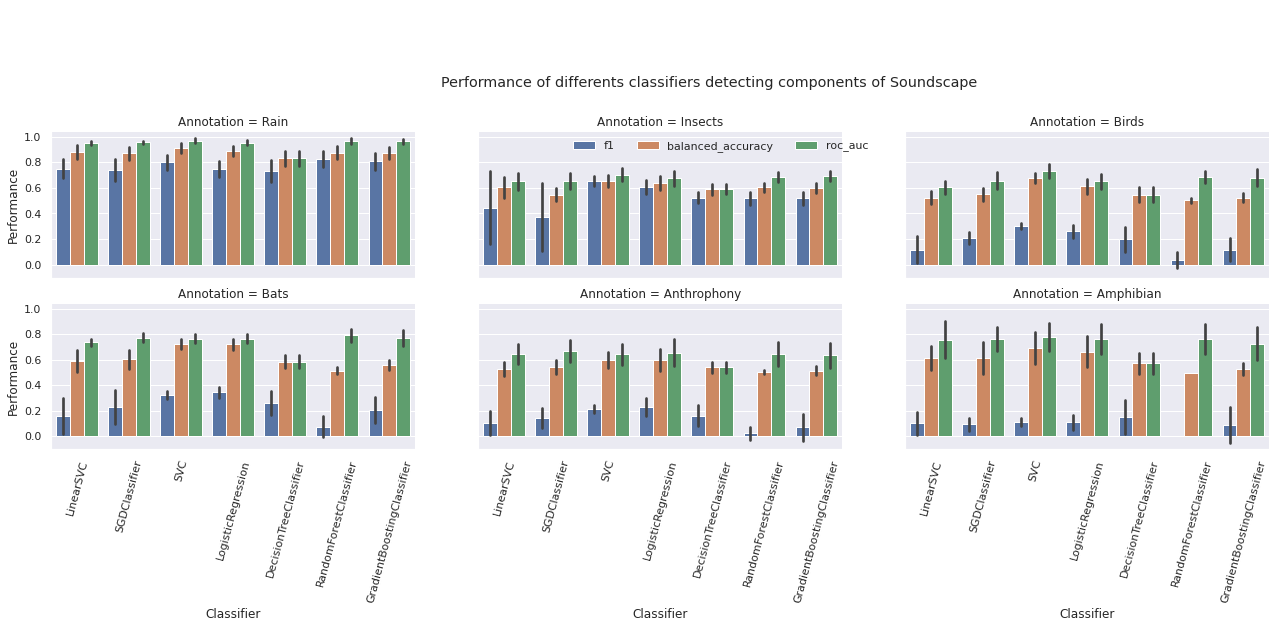

In [ ]:
ax = sns.catplot(data=df_scores,x='Classifier',y='Performance',hue='Metric Score', kind='bar',
                 ci="sd",col="Annotation",col_wrap=3,
                 height=3, aspect=2)

ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Performance of differents classifiers detecting components of Soundscape', 
                fontdict = {'fontsize' : 25})

sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.08), ncol=3, title=None, frameon=False,)
ax.set_xticklabels(rotation=75)
plt.show()



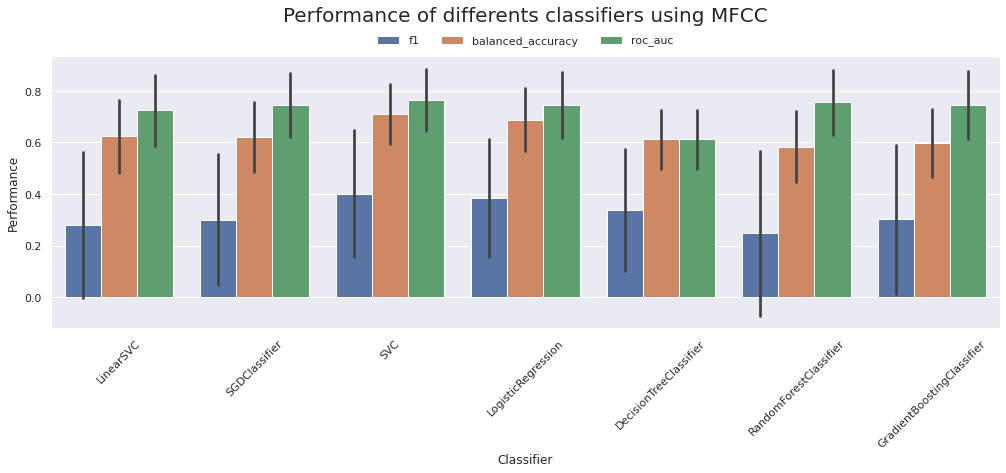

In [ ]:
ax = sns.barplot(data=df_scores,x='Classifier',y='Performance',hue='Metric Score',ci="sd")
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.set_title('Performance of differents classifiers using MFCC', fontdict = {'fontsize' : 20}, pad=35)
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_scores.groupby(['Classifier','Metric Score'])['Performance'].agg(['mean', 'std'])

mean       std
Classifier                 Metric Score                         
DecisionTreeClassifier     balanced_accuracy  0.611369  0.116316
                           f1                 0.338521  0.237680
                           roc_auc            0.611466  0.116187
GradientBoostingClassifier balanced_accuracy  0.598937  0.133708
                           f1                 0.302214  0.291990
                           roc_auc            0.745309  0.132953
LinearSVC                  balanced_accuracy  0.623826  0.141778
                           f1                 0.279637  0.286781
                           roc_auc            0.724429  0.139540
LogisticRegression         balanced_accuracy  0.687609  0.123241
                           f1                 0.383999  0.231447
                           roc_auc            0.744576  0.129892
RandomForestClassifier     balanced_accuracy  0.583571  0.139632
                           f1                 0.247156  0.321984
                           roc_auc            0.755905  0.127823
SGDClassifier              balanced_accuracy  0.621756  0.136769
                           f1                 0.299294  0.256242
                           roc_auc            0.745625  0.126187
SVC                        balanced_accuracy  0.710066  0.118343
                           f1                 0.400885  0.248715
                           roc_auc            0.765284  0.121768

In [ ]:
df_scores['Classifier'] = df_scores['Classifier'].replace({'LinearSVC':'Linear SVC',
                                                    'SGDClassifier':'SGD',
                                                    'LogisticRegression':'Logistic Regression',
                                                    'DecisionTreeClassifier':'Decision Tree',
                                                    'RandomForestClassifier':'Random Forest', 
                                                    'GradientBoostingClassifier':'Gradient Boosting',
                            
                                                     })

df_scores['Metric Score'] = df_scores['Metric Score'].replace({'f1':'F1',
                                                    'roc_auc':'ROC AUC',
                                                    'balanced_accuracy':'Accuracy',

                            
                                                     })

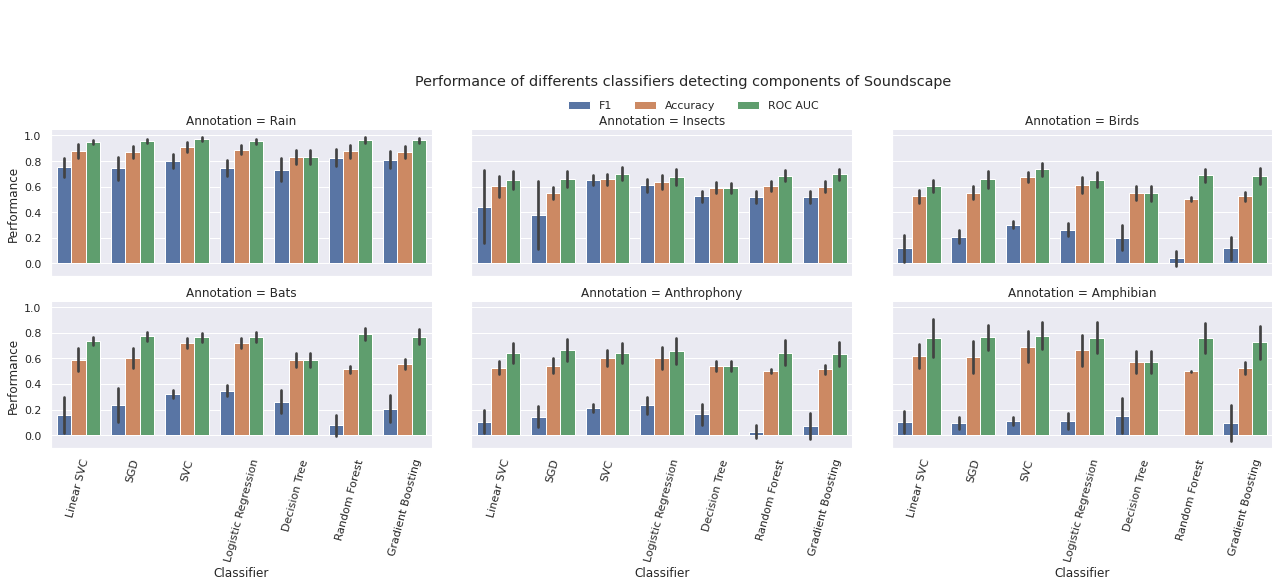

In [ ]:
ax = sns.catplot(data=df_scores,x='Classifier',y='Performance',hue='Metric Score', kind='bar',
                 ci="sd",col="Annotation",col_wrap=3,
                 height=3, aspect=2)

ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Performance of differents classifiers detecting components of Soundscape', 
                fontdict = {'fontsize' : 25})

sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.08), ncol=3, title=None, frameon=False,)
ax.set_xticklabels(rotation=75)
plt.show()

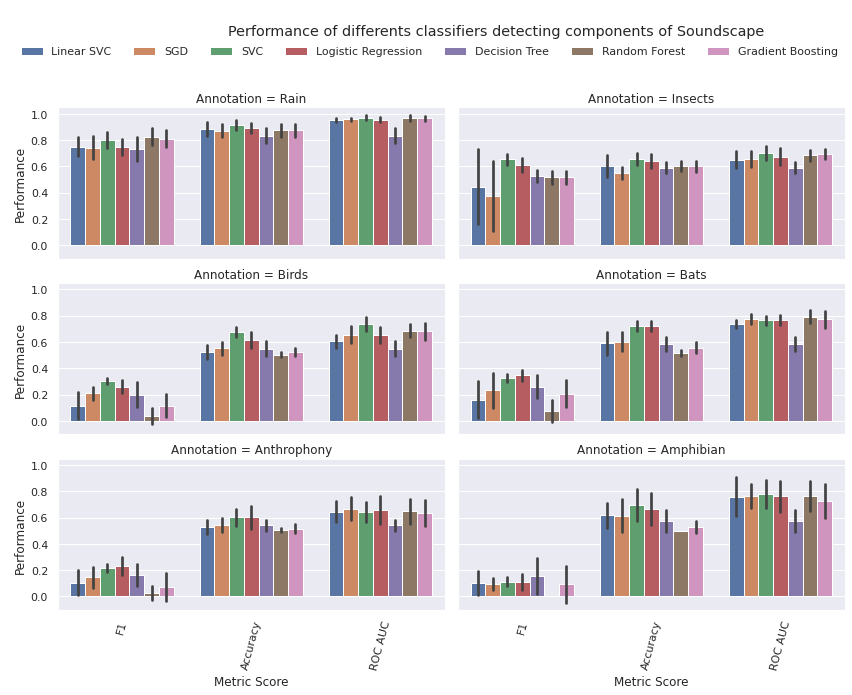

In [ ]:
ax = sns.catplot(data=df_scores,hue='Classifier',y='Performance',x='Metric Score', kind='bar',
                 ci="sd",col="Annotation",col_wrap=2,
                 height=3, aspect=2)

ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Performance of differents classifiers detecting components of Soundscape', 
                fontdict = {'fontsize' : 25})

sns.move_legend(ax, "lower center", bbox_to_anchor=(.425, 0.97), ncol=7, title=None, frameon=False,)
ax.set_xticklabels(rotation=75)
plt.show()

In [ ]:
df_scores.groupby(['Annotation','Classifier','Metric Score'])['Performance'].agg(['mean', 'std'])

mean       std
Annotation Classifier        Metric Score                    
Amphibian  Decision Tree     Accuracy      0.572800  0.087530
                             F1            0.152775  0.143510
                             ROC AUC       0.573184  0.088084
           Gradient Boosting Accuracy      0.525993  0.049963
                             F1            0.091667  0.149330
...                                             ...       ...
Rain       SGD               F1            0.741520  0.091505
                             ROC AUC       0.956315  0.013792
           SVC               Accuracy      0.912110  0.040258
                             F1            0.800166  0.061102
                             ROC AUC       0.970975  0.018072

[126 rows x 2 columns]

-----------------------------------Analysis of category: Rain -----------------------------------


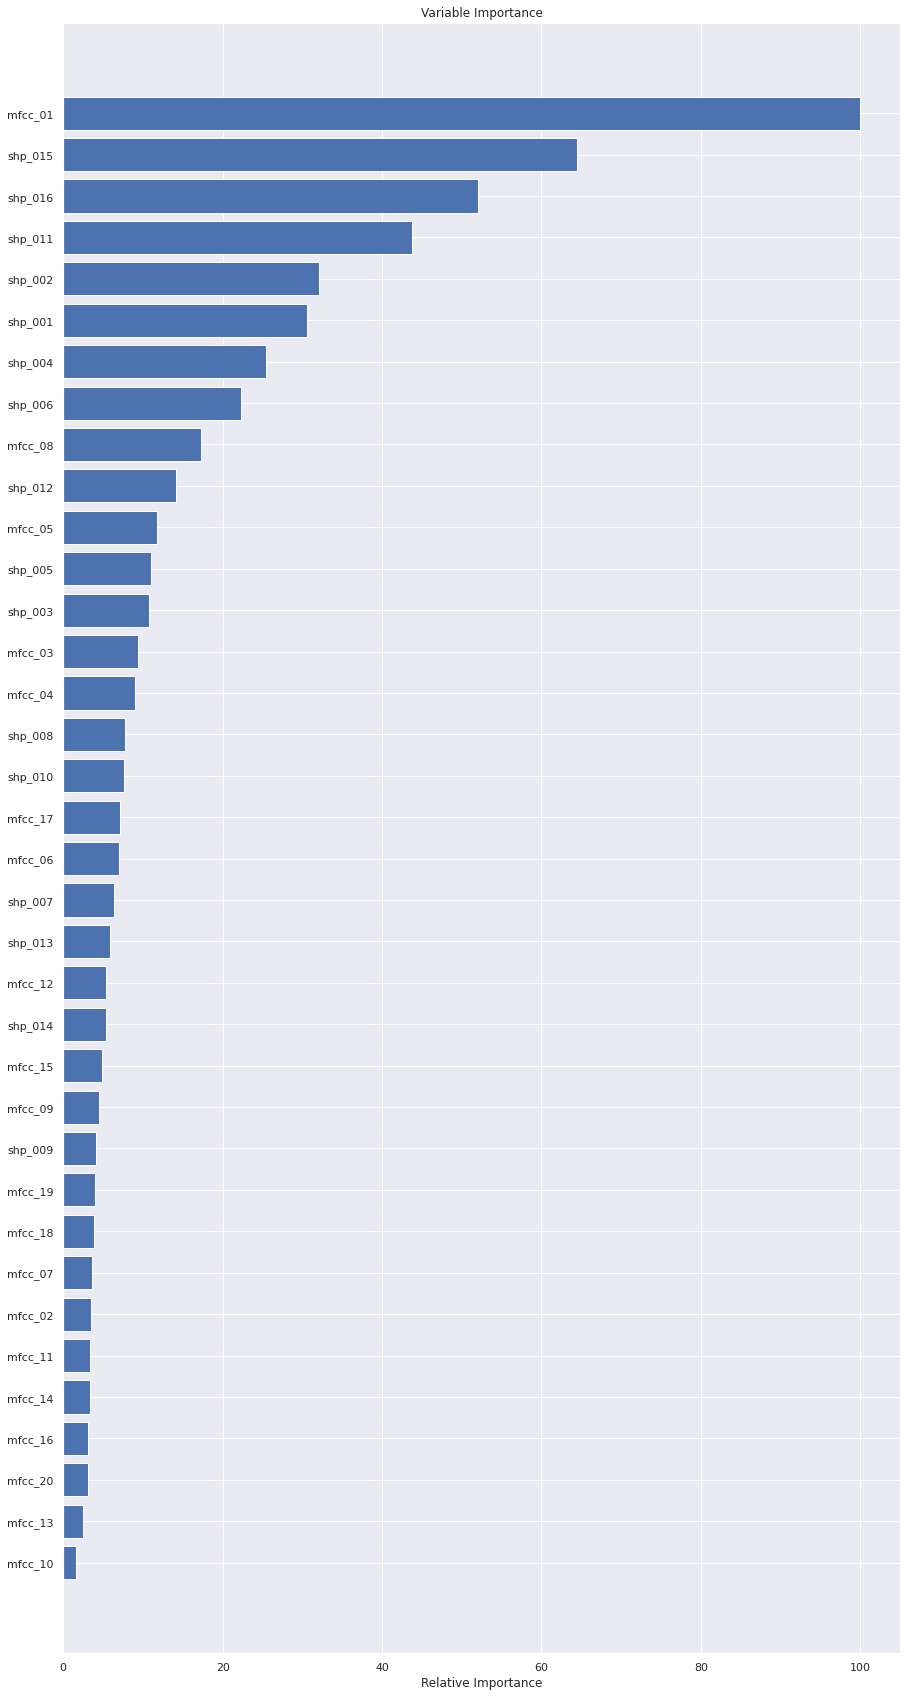

In [ ]:
for label_name in ['Rain']:#'Insects','Birds','Bats','Anthrophony','Amphibian']:

    fea_importances = []

    #%% Split development and test data
    print('-----------------------------------Analysis of category:',label_name,'-----------------------------------')

    X = df_features[[i for i in df_features.columns if 'mfcc' in i or 'shp' in i]]
    y = (df_features.label==label_name).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        shuffle=True,
                                                        random_state=42) 
    
    model = RandomForestClassifier(class_weight='balanced') #GradientBoostingClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    # Plot feature importance
    feature_importance = model.feature_importances_
    fea_importances.append(feature_importance)
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(15, 30))
    pos = np.arange(sorted_idx.shape[0]) + .8
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
#             plt.savefig('GBRT_graphs' + str(NUM_TEST_PER_USER) + '/mixed_all/' + feature_sets_names[i] + '/' + str(count) + '.png', bbox_inches='tight')
    plt.show()





*   https://scikit-learn.org/stable/modules/ensemble.html#feature-importance
*   https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
*   https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
*   https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance
*   https://christophm.github.io/interpretable-ml-book/feature-importance.html
*   https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
*   https://scikit-learn.org/stable/modules/permutation_importance.html

In [ ]:
feature_importance

array([100.        ,   3.54812489,   9.42928828,   9.04434586,
        11.77857391,   6.95579563,   3.56566135,  17.24563237,
         4.44425313,   1.57716611,   3.37716293,   5.42710297,
         2.44504727,   3.32489087,   4.92008491,   3.08354438,
         7.15395892,   3.90321156,   3.96374426,   3.06417564,
        30.59161127,  32.08682409,  10.74198518,  25.42847835,
        10.96040764,  22.27530027,   6.35509555,   7.7844898 ,
         4.15417132,   7.61692393,  43.71640209,  14.15888152,
         5.84121305,   5.34956247,  64.47756919,  52.00403554])